In [93]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import seaborn as sns
from gerrychain import Graph, GeographicPartition, Partition, Election, accept
from gerrychain.updaters import Tally, cut_edges
import glob
import functools
import operator
import argparse

In [94]:
ST = "CO"
NUM_DISTRICTS = 8
MIN_COL = "HISP"
iters = 1000

In [95]:
def foldl(func, acc, xs):
  return functools.reduce(func, xs, acc)

foldr = lambda func, acc, xs: functools.reduce(lambda x, y: func(y, x), xs[::-1], acc)

In [96]:
def get_state_runs(state, seats, iters=100, pop_bal=2.0, min_col="HISP",
                   ls=[2,5,10,20,40,80], ps=[0.25, 0.125, 0.0625]):
    """ Reads in short burst and biased run results. and returns dictionary of parameter and matrix of run results.
        Args:
          * state: str      -- abbreviation of state to pull data from
          * seats: int      -- number of state House districts
          * iters: int      -- number of steps (observed plans) in chain
          * pop_bal: float  -- population balance of plans in chain
          * min_col: str    -- column name of population to look at majority-minority districts for
          * ls: int list    -- list of the burst lengths for the short burst runs
          * ps: float list  -- list of acceptance probabilities of "worse preforming" plans for the biased runs
    """
    results = {}

    for l in ls:
        sb_runs = glob.glob("pickle/{}_dists{}_{}opt_{}%_100_sbl10_score0_*.npy".format(state, seats, 
                                                                                                min_col, pop_bal))
        results[str(l)] = np.zeros((len(sb_runs), iters))
        for i, run in enumerate(sb_runs):
            results[str(l)][i] = np.load(run).flatten()
    for p in ps:
        tilt_runs = glob.glob("pickle/{}_dists{}_{}opt_{}%_100_p10_*.npy".format(state, seats, 
                                                                                         min_col, pop_bal))
        results[str(p)] = np.zeros((len(tilt_runs), iters))
        for i, run in enumerate(tilt_runs):
            results[str(p)][i] = np.load(run).flatten()
    return results

In [97]:
def create_state_df(runs, iters=100):
    df_st = pd.DataFrame()
    for l in runs.keys():
        for i in range(runs[l].shape[0]):
            df = pd.DataFrame()
            df["Step"] = np.arange(iters)
            df["Maximum"] = np.maximum.accumulate(runs[l][i].flatten())
            df["run-type"] = "Short Burst" if float(l) > 1 else "Biased Run" if float(l) < 1 else "Unbiased Run"
            df["param"] = "b = {}".format(l) if float(l) > 1 else "q = {}".format(l)
            df_st = pd.concat([df_st, df], ignore_index=True)
    return df_st

In [98]:
## gather biased and short burst runs
state_runs = get_state_runs(ST, NUM_DISTRICTS, ls=[2,5,10,25,50,100,200], 
                              pop_bal=4.5, min_col=MIN_COL)

In [99]:
df_state = create_state_df(state_runs)

/var/folders/7d/zg9bnpnx227_d00djx7z944r0000gn/T/ipykernel_36469/873229103.py:12: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.lineplot(x="Step", y="Maximum", hue="param",style="run-type", palette=cmap_no_light,


FileNotFoundError: [Errno 2] No such file or directory: '/Users/colininns/Documents/School/USF/MSCS/Redistricting/Final/Colorado-Redistricting-Analysis/MAUP/Colorado/plots/CO_maxes_all_HISP.png'

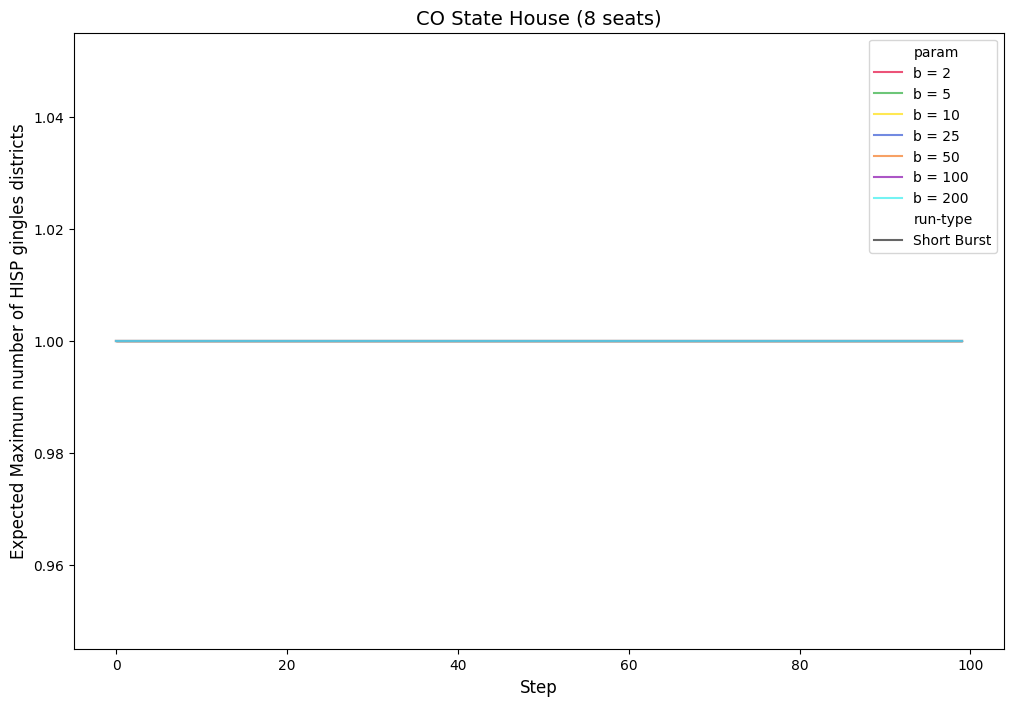

In [100]:
## Plot runs
cmap_no_light = sns.color_palette(['#e6194b', '#3cb44b', '#ffe119', '#4363d8', 
                                   '#f58231', '#911eb4', '#46f0f0', '#f032e6', 
                                   '#808000', '#008080', '#9a6324', '#800000', 
                                   '#aaffc3', '#000075'], n_colors=len(df_state.param.unique()))


plt.figure(figsize=(12,8))

plt.title("{} State House ({} seats)".format(ST, NUM_DISTRICTS),fontsize=14)

sns.lineplot(x="Step", y="Maximum", hue="param",style="run-type", palette=cmap_no_light,
             data=df_state, ci="sd", estimator='mean', alpha=0.75)

# enacted = 28 # check number
# plt.axhline(enacted, label="Enacted Plan", c="k", linestyle='dashdot')

plt.ylabel("Expected Maximum number of {} gingles districts".format(MIN_COL),fontsize=12)
plt.xlabel("Step",fontsize=12)
plt.legend()
plt.savefig("plots/{}_maxes_all_{}.png".format(ST, MIN_COL), dpi=200, bbox_inches='tight')
plt.close()